## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

## Helper Functions
Helper functions that was learned from leason!

In [3]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', channel='gray', thresh_min=0, thresh_max=255):
    if channel == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif channel == 'R':
        gray = img[:,:,0]
    elif channel == 'G':
        gray = img[:,:,1]
    elif channel == 'B':
        gray = img[:,:,2]
        
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [4]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, channel='gray', mag_thresh=(0, 255)):
    if channel == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif channel == 'R':
        gray = img[:,:,0]
    elif channel == 'G':
        gray = img[:,:,1]
    elif channel == 'B':
        gray = img[:,:,2]
        
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [5]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, channel='gray', thresh=(0, np.pi/2)):
    if channel == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif channel == 'R':
        gray = img[:,:,0]
    elif channel == 'G':
        gray = img[:,:,1]
    elif channel == 'B':
        gray = img[:,:,2]
        
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [6]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Perspective Transform

In [15]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

For simplicity, we choose four source points manually.There are many other ways to select source points. For example, many perspective transform algorithms will programmatically detect four source points in an image based on edge or corner detection and analyzing attributes like color and surrounding pixels.

In [17]:
# Show test image in interactive window for choose four vertices for perspective transformation
%matplotlib qt

image = mpimg.imread('test_images/straight_lines2.jpg')

plt.imshow(image)
plt.show()

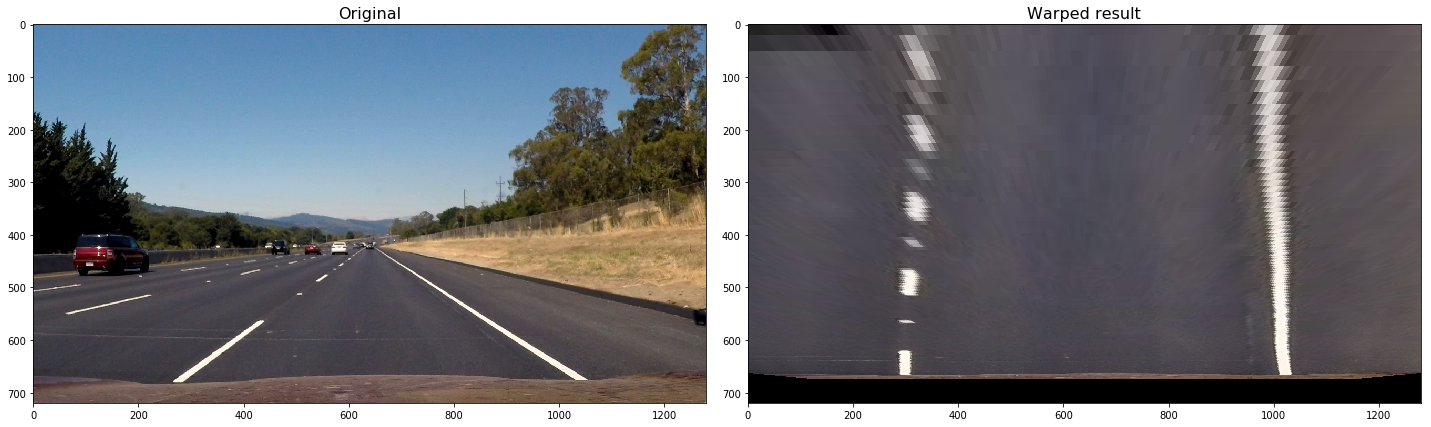

In [21]:
%matplotlib inline

src = np.float32([[739, 478], [1035 ,662],[284, 662], [549, 478]])
dsr = np.float32([[1035, 478], [1035 ,662],[284, 662], [284, 478]])

image = mpimg.imread('test_images/straight_lines2.jpg')
warped = perspect_transform(image, src, dsr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original', fontsize=16)

ax2.imshow(warped)
ax2.set_title('Warped result', fontsize=16)

plt.show()

## Test Images
Build a pipeline to work on the images in the directory "test_images"

In [22]:
import os
testing_names = os.listdir("test_images/")
testing_names

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

## Build an Advanced Lane Finding Pipeline

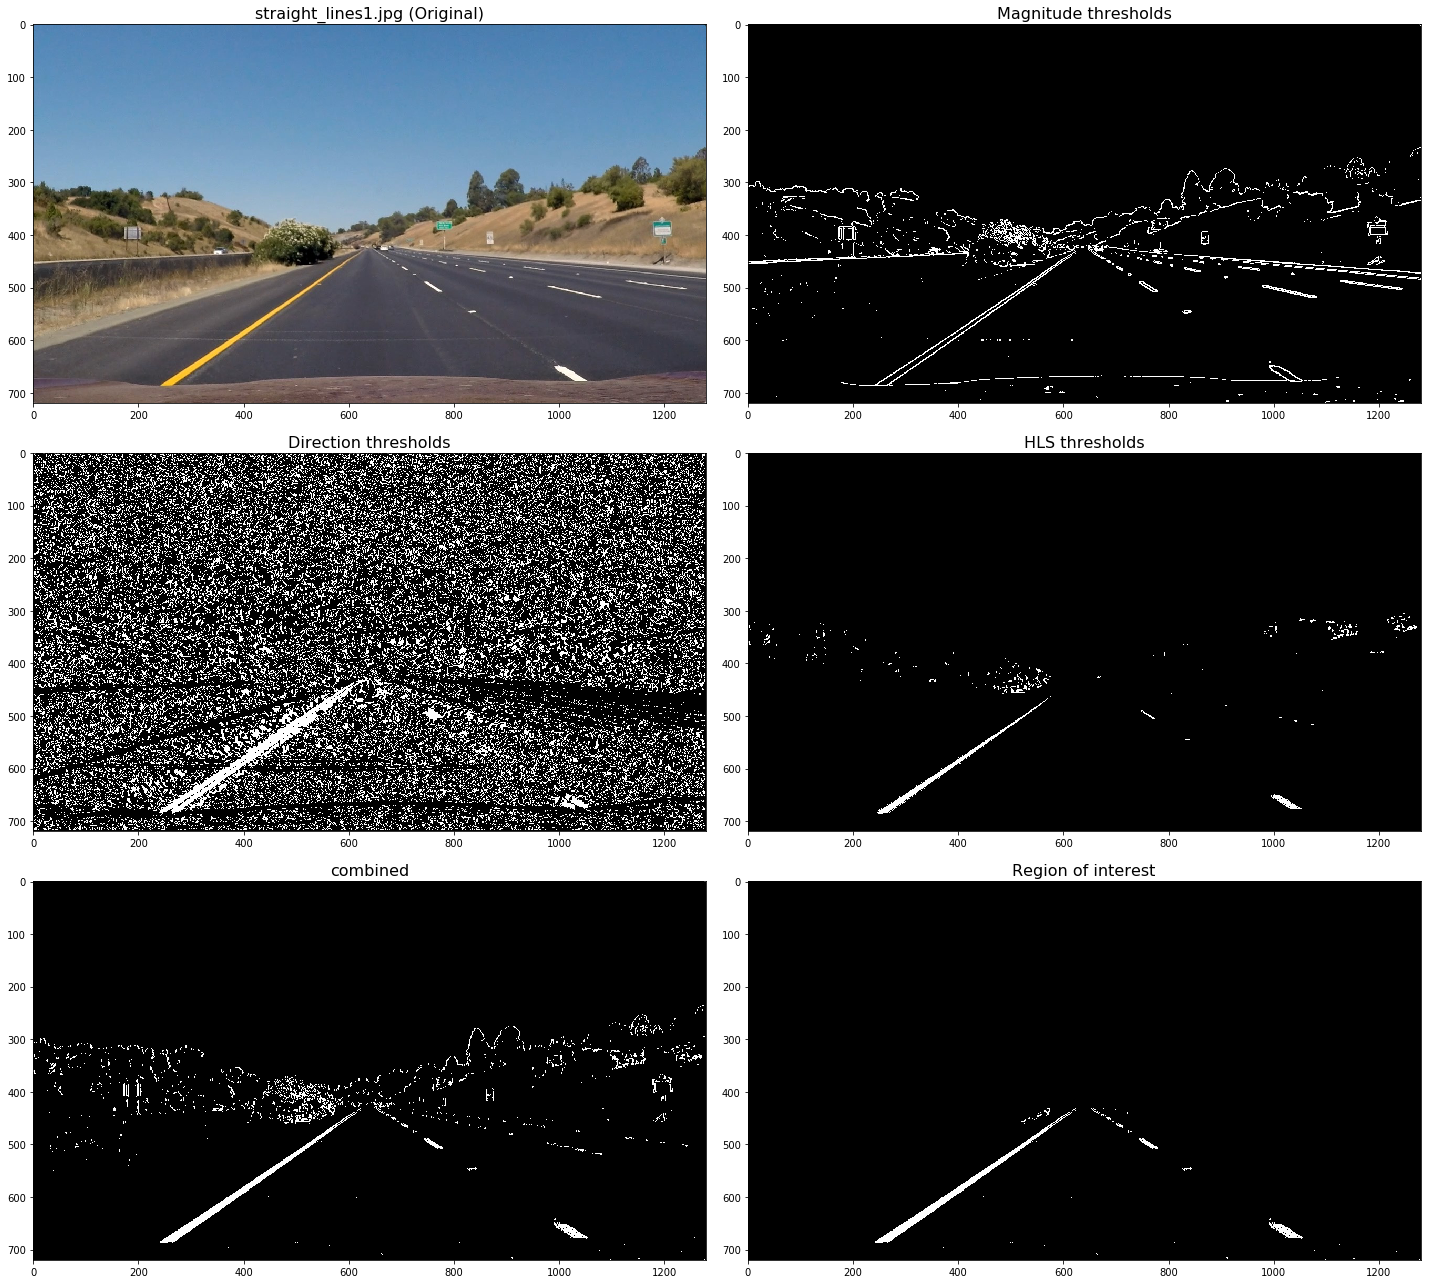

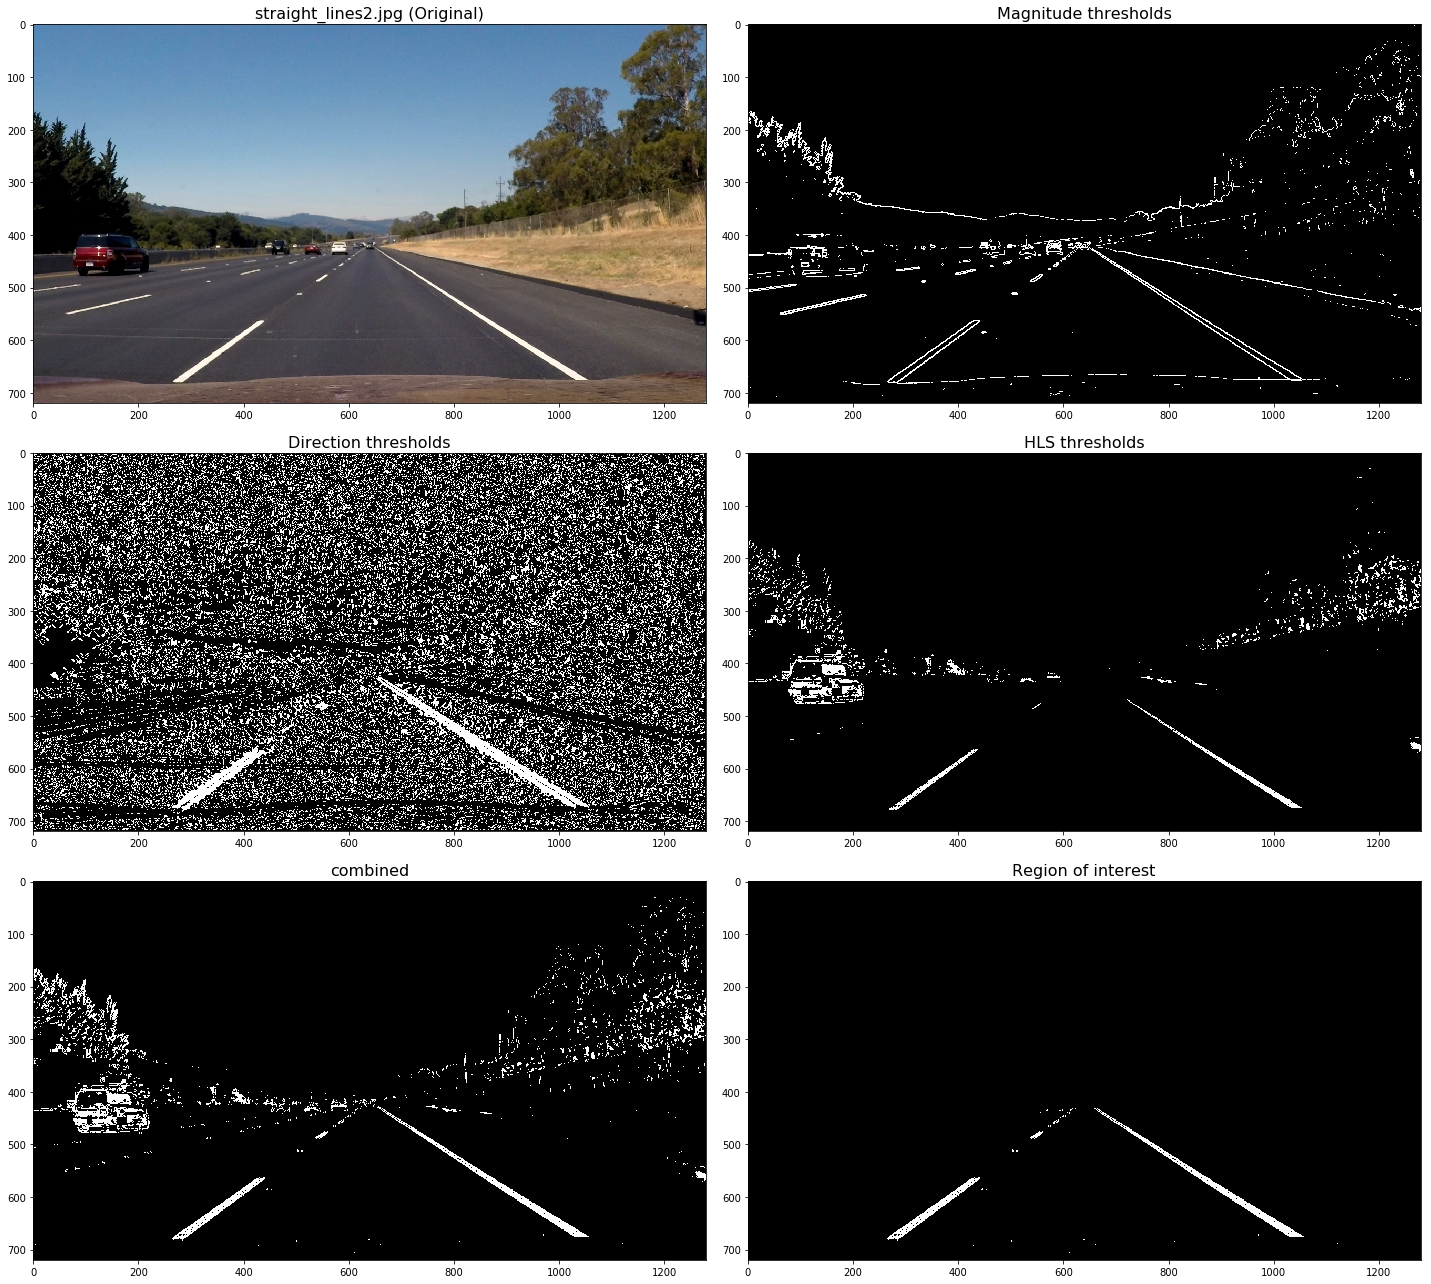

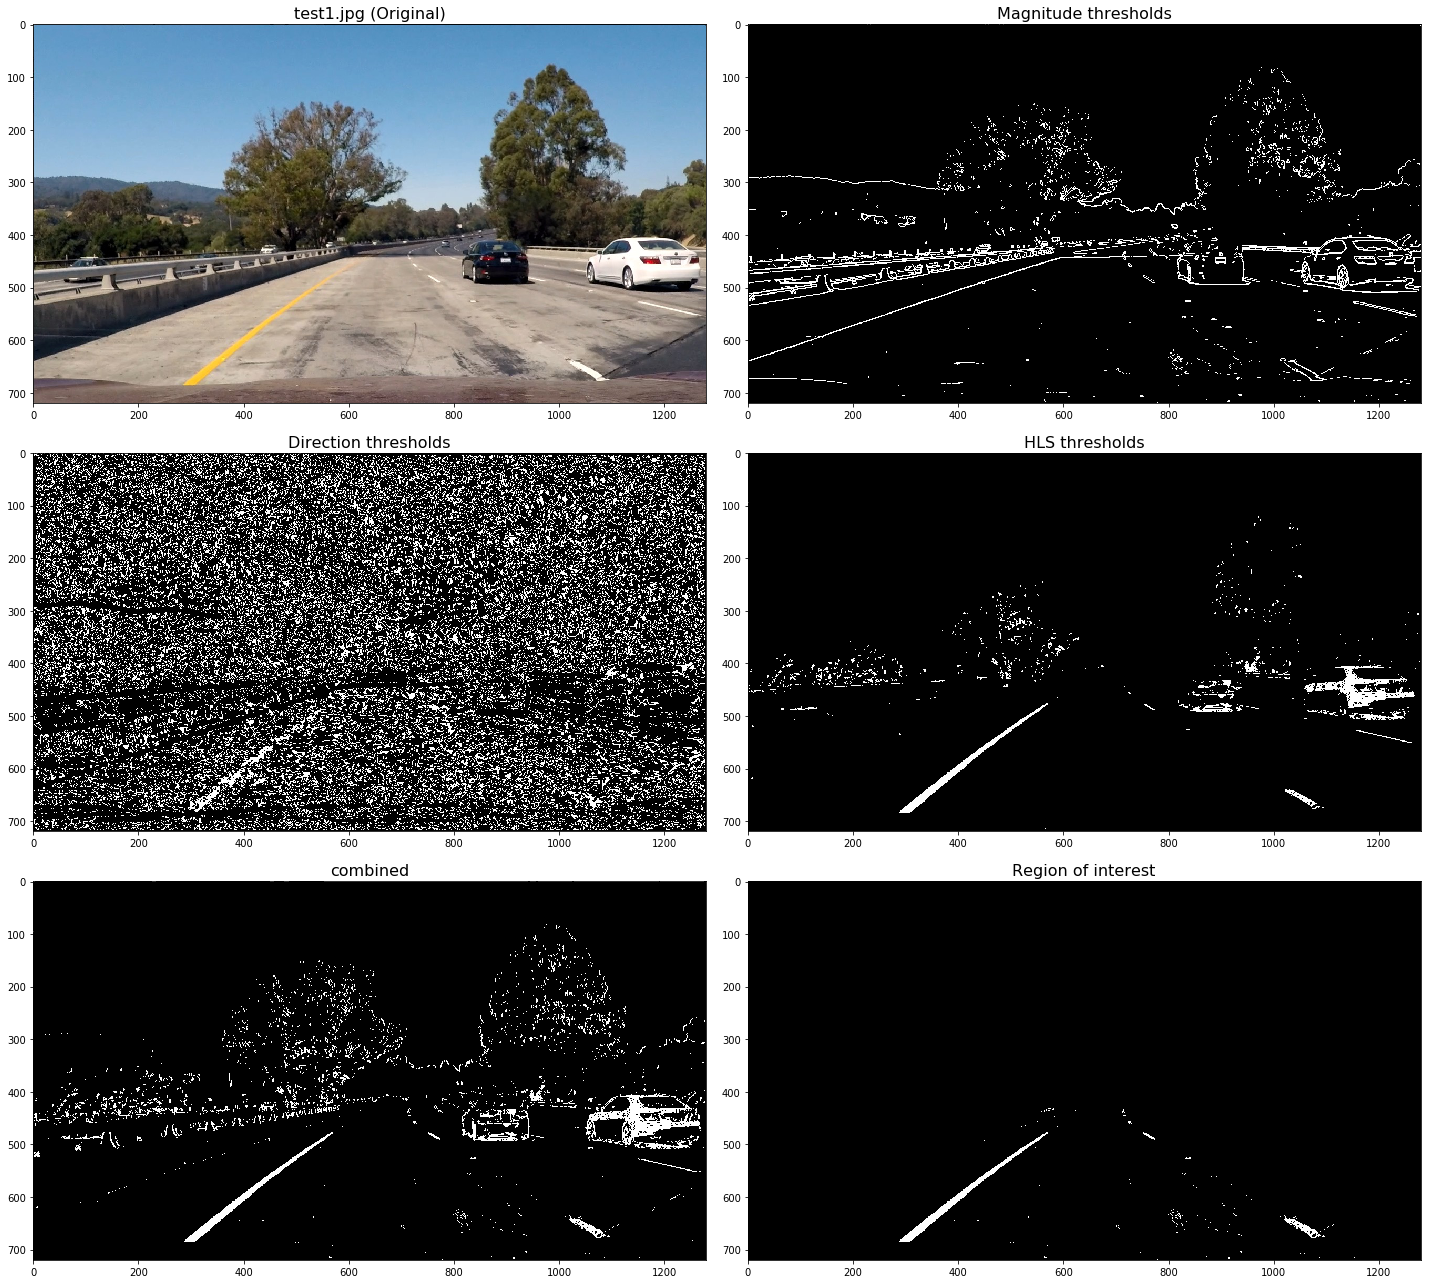

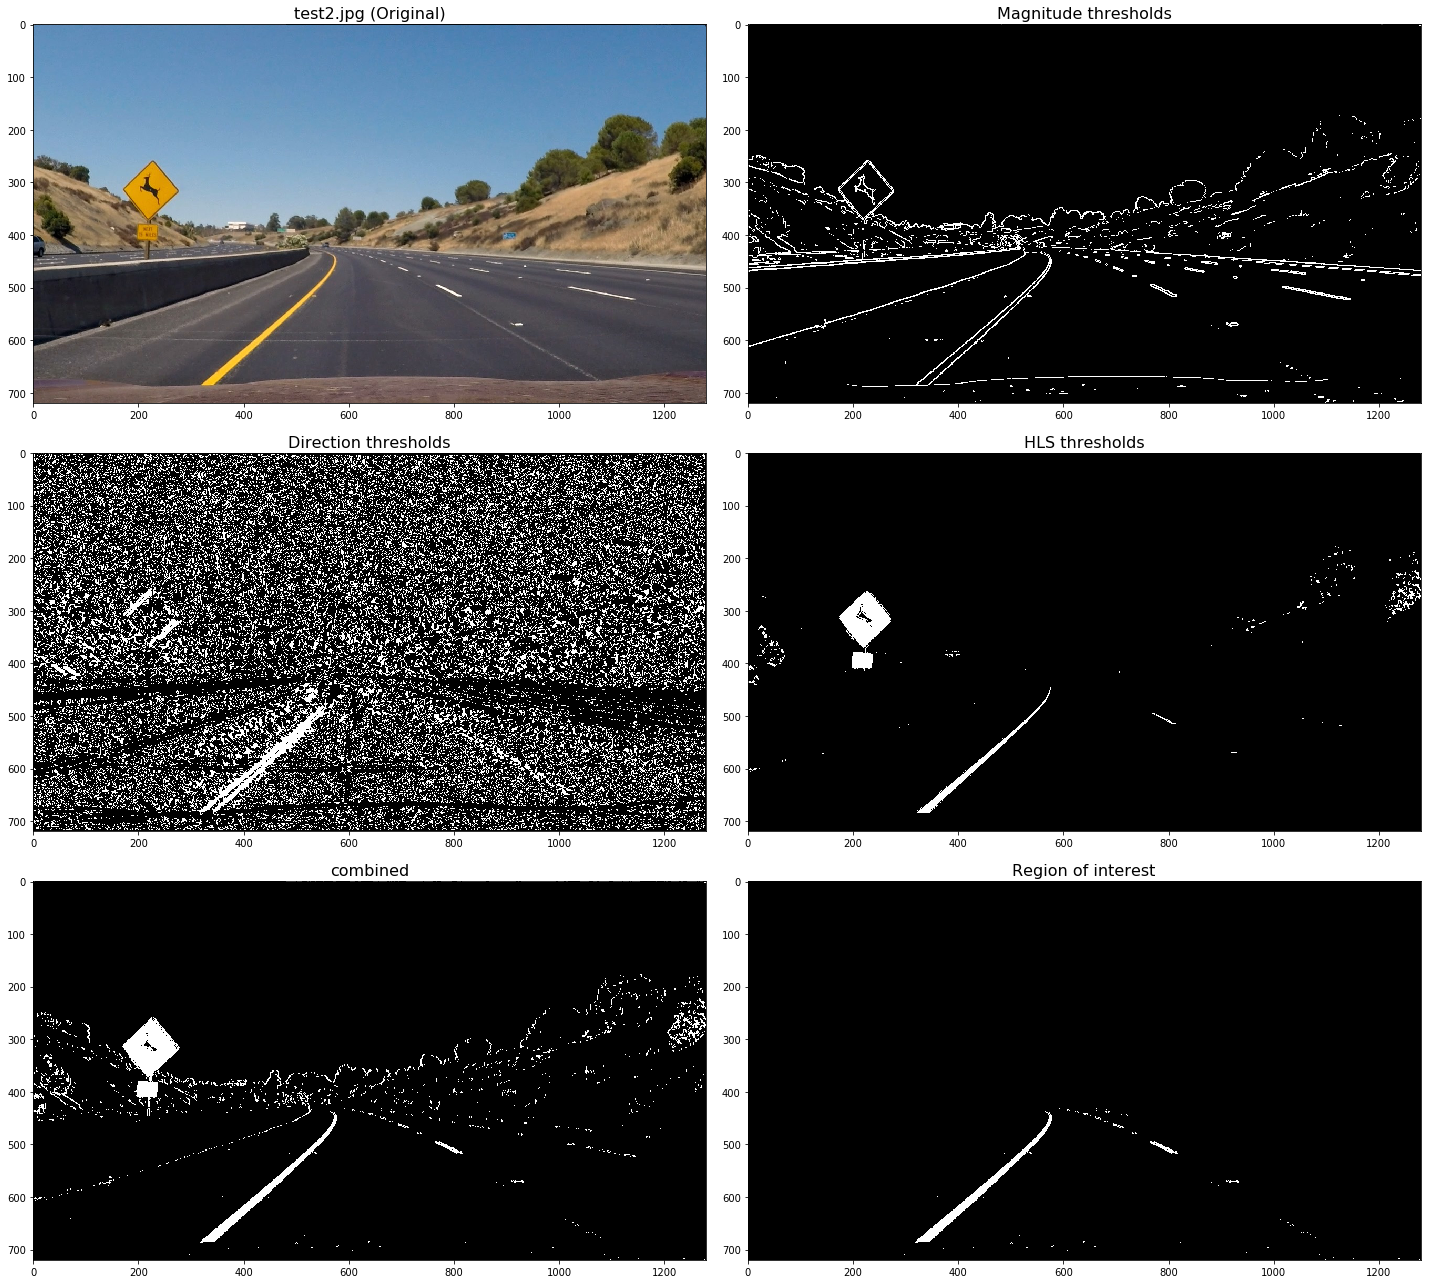

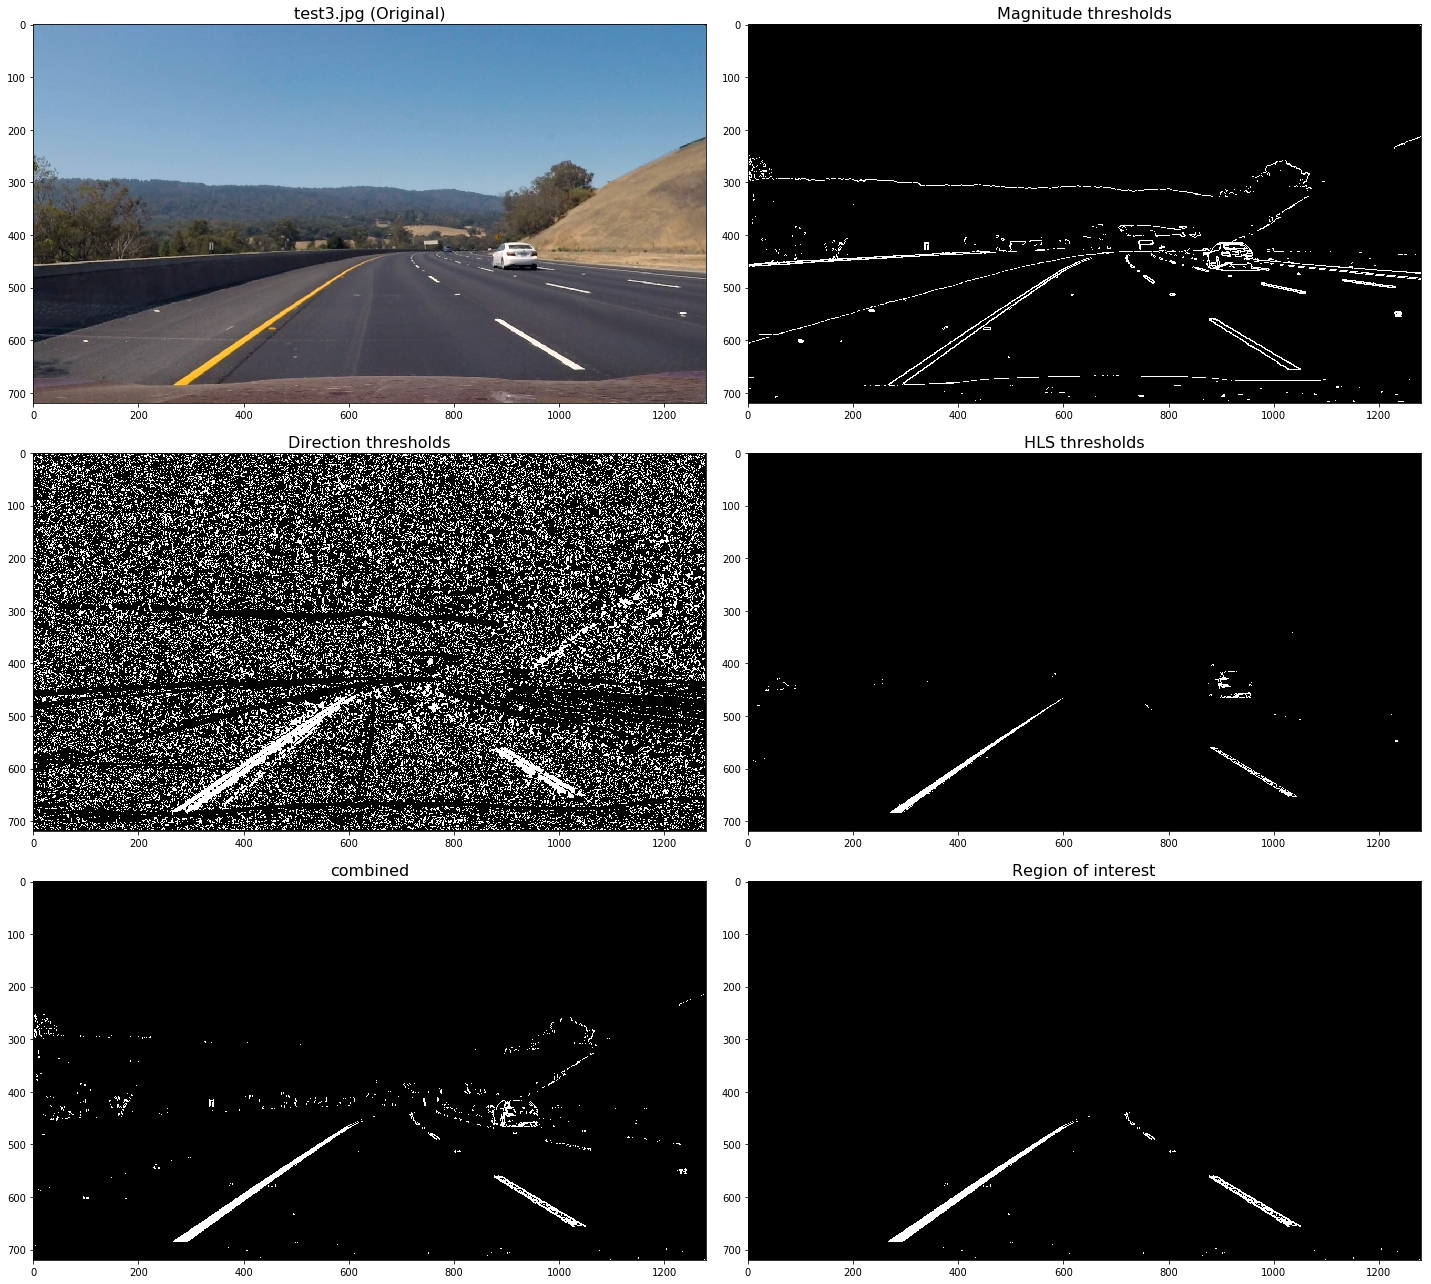

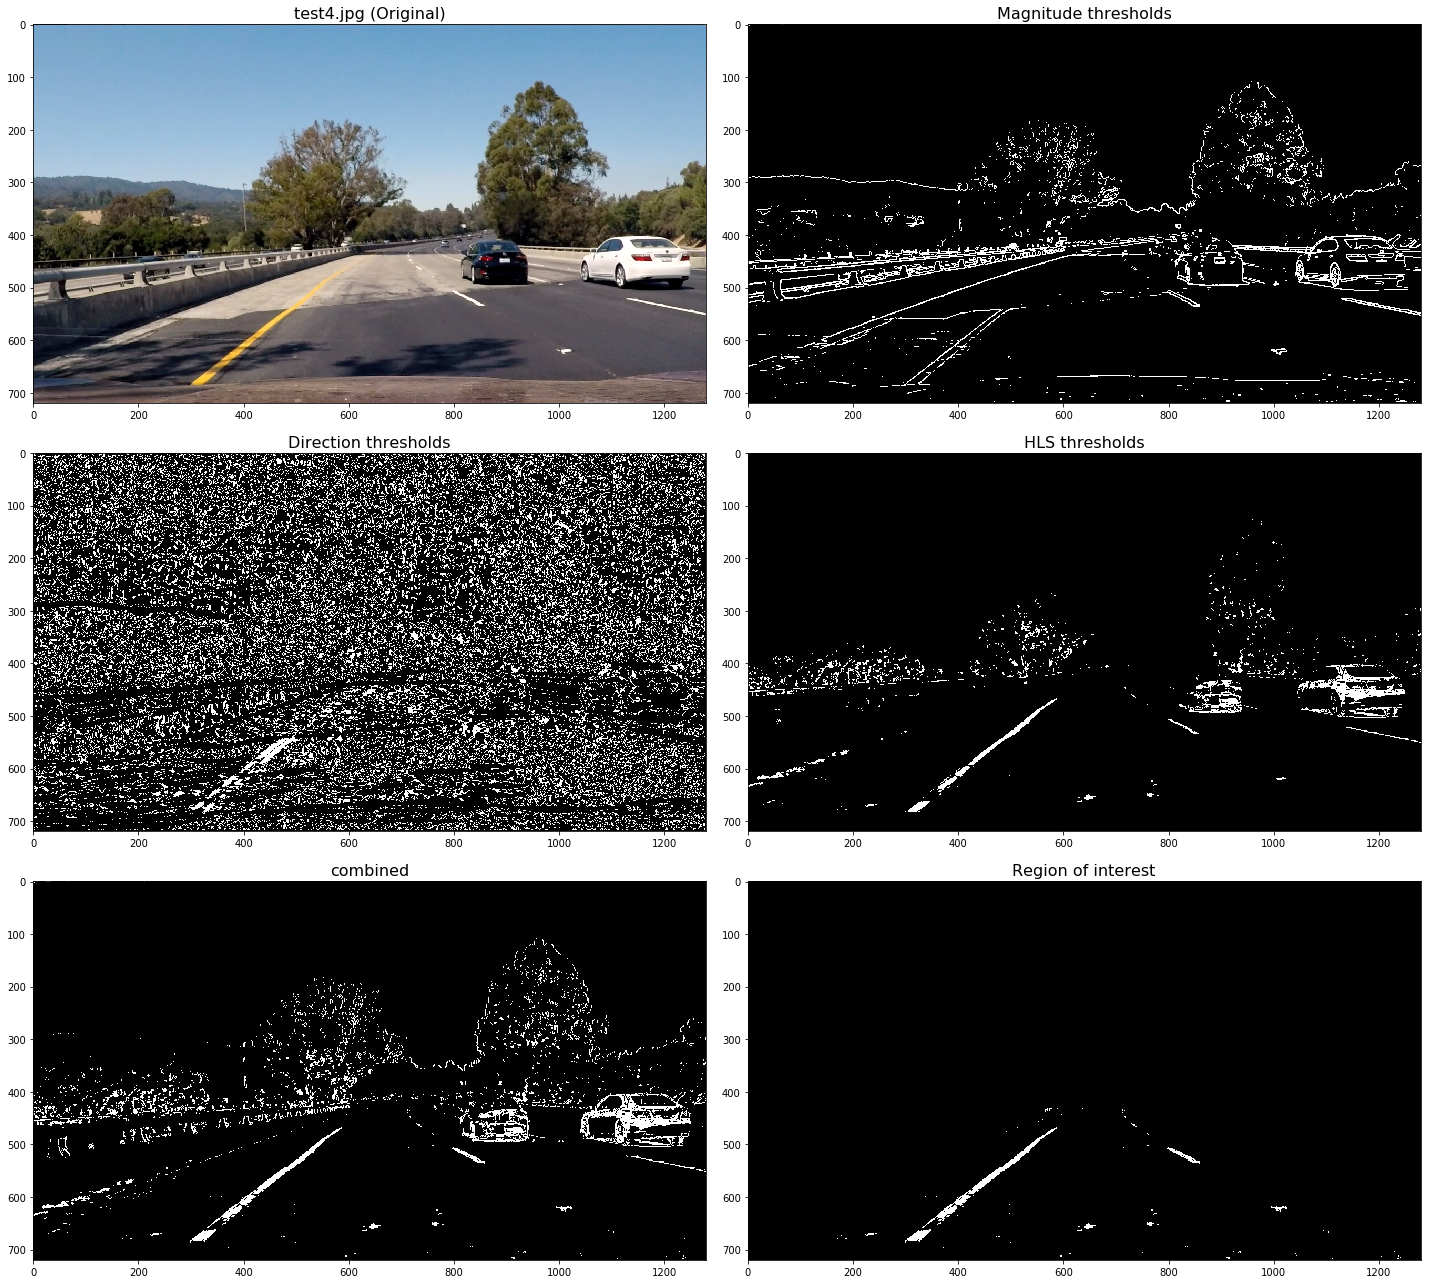

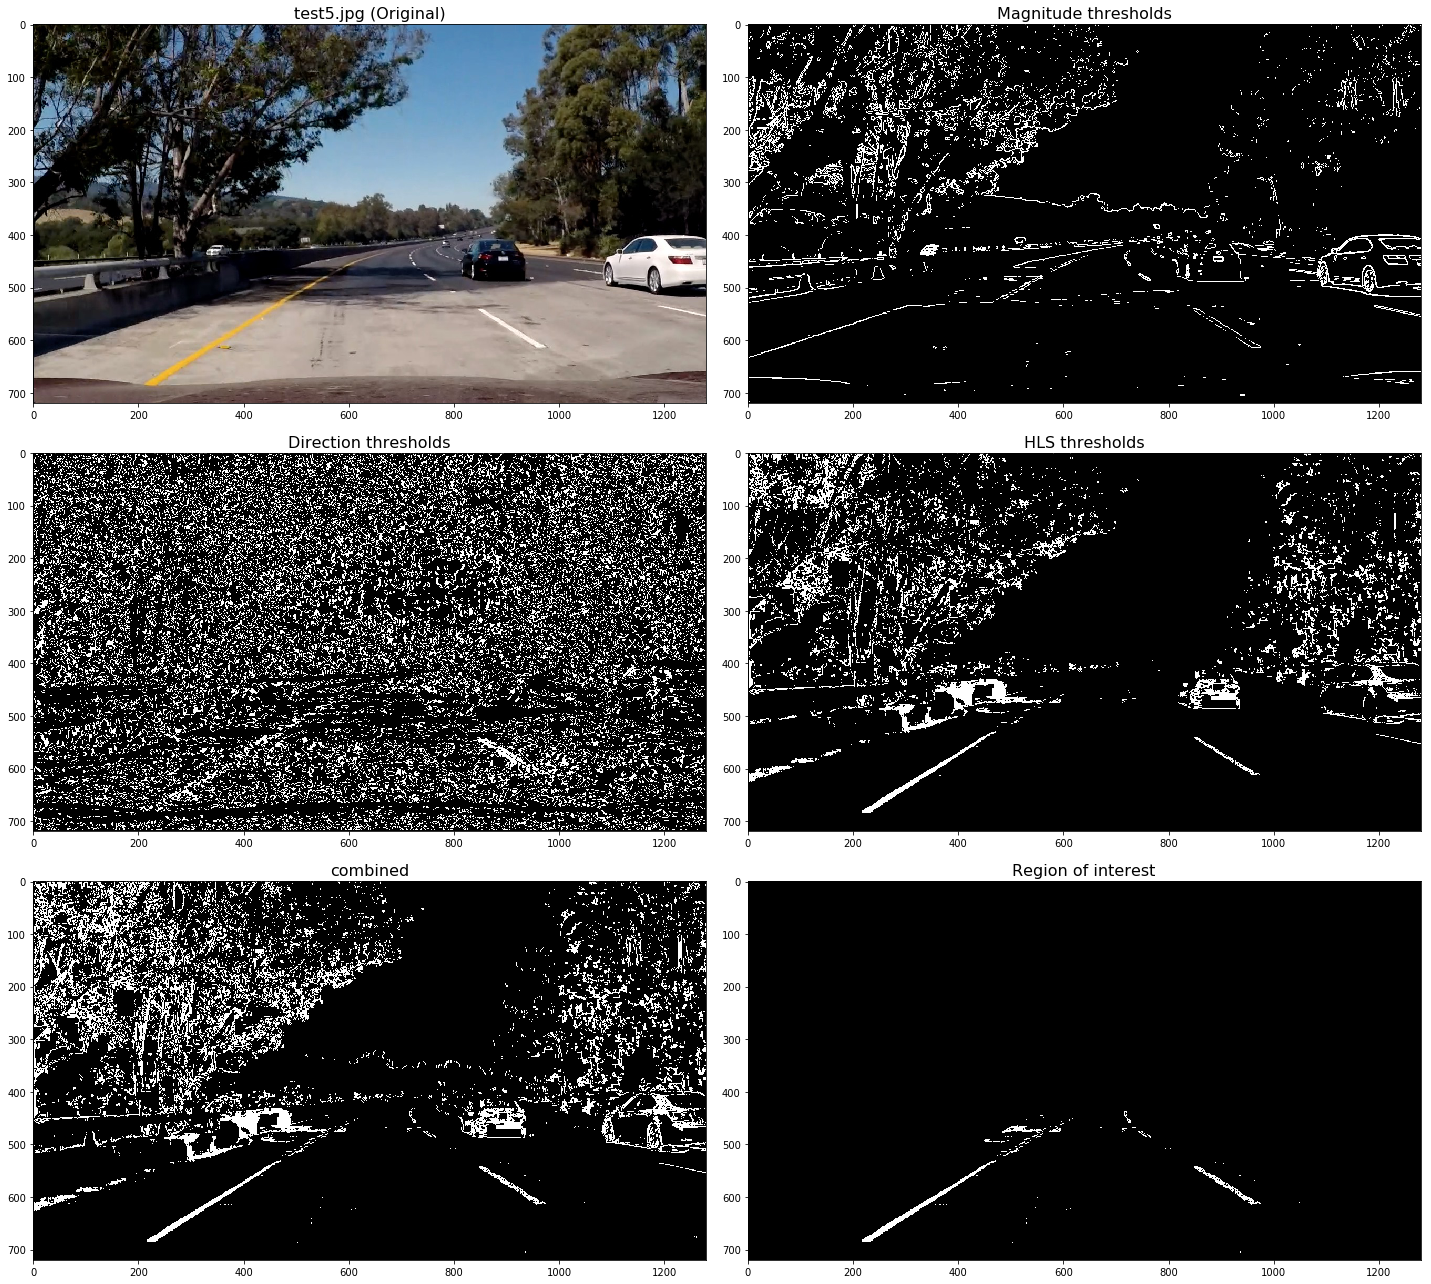

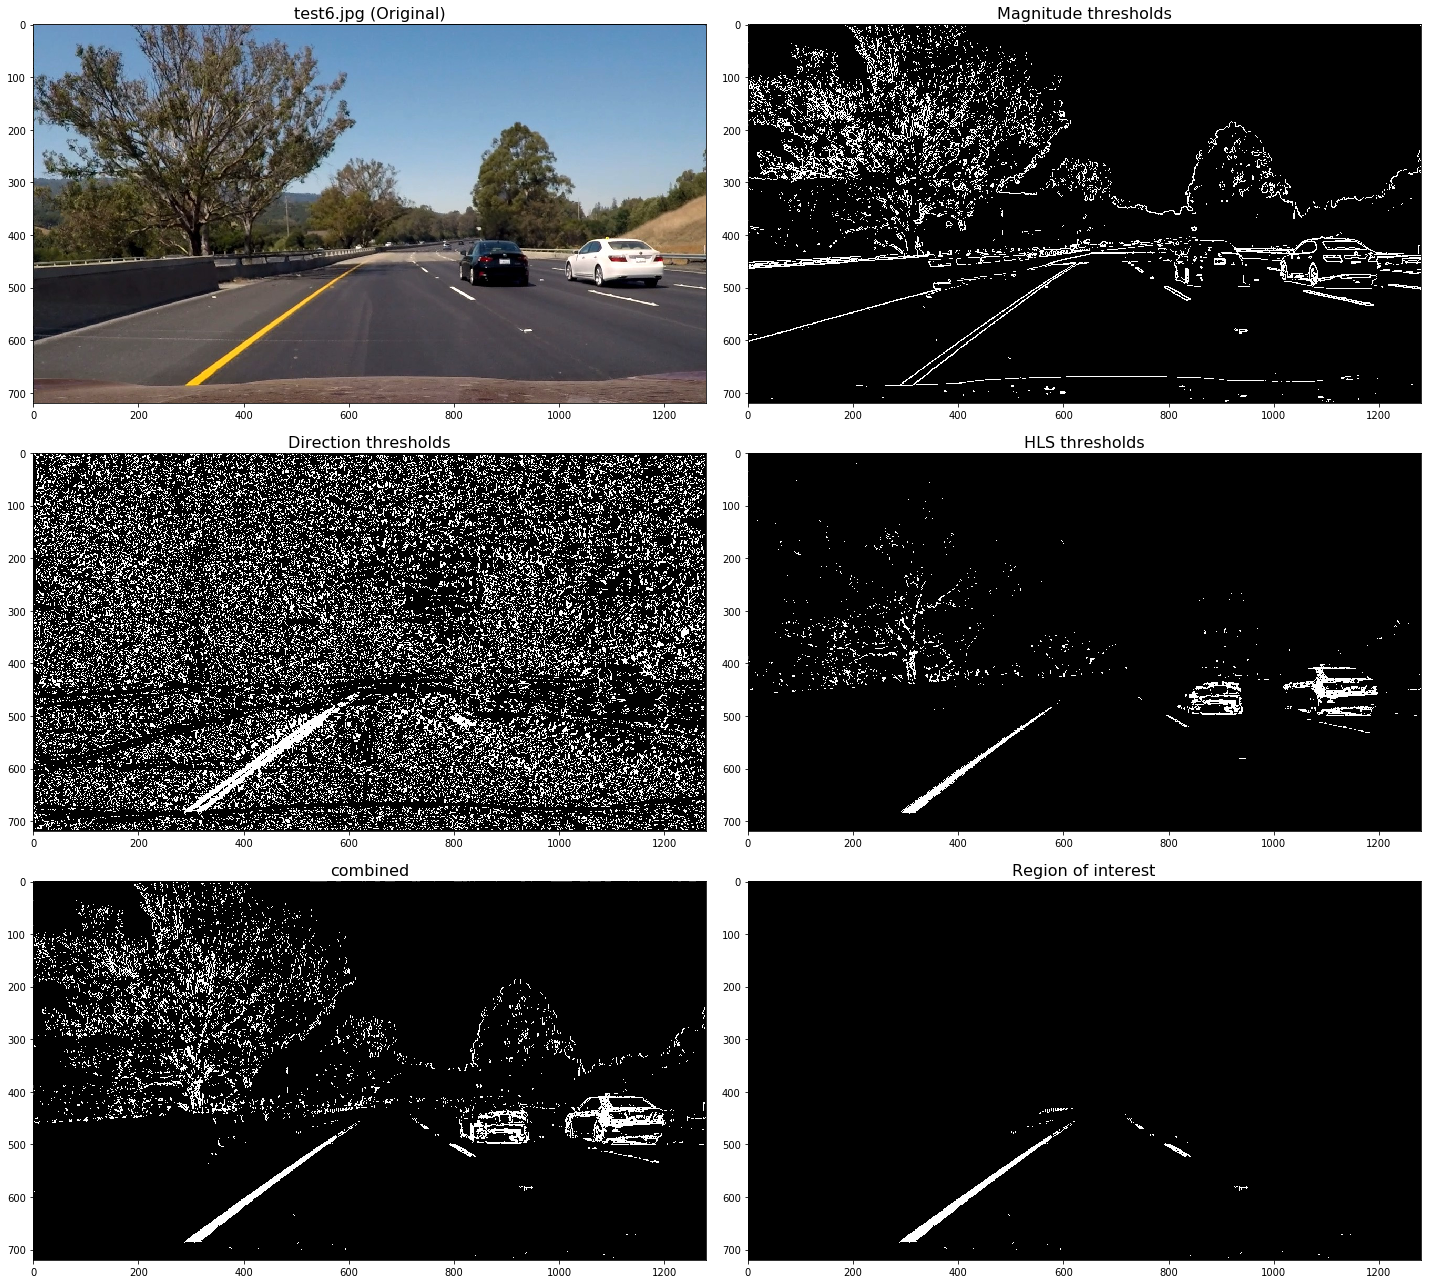

In [34]:
%matplotlib inline

for image_name in testing_names:
    f, axes = plt.subplots(3, 2, figsize=(20, 18))
    f.tight_layout()
    
    image = mpimg.imread('test_images/' + image_name)    
    
    imshape = image.shape
    
    vertices = np.array(
        [[(0,imshape[0]),
        ((int(imshape[1]*4/9)), int(imshape[0]*3/5)), 
        (int((imshape[1]*5/9)), int(imshape[0]*3/5)),
        (imshape[1],imshape[0])]], 
        dtype=np.int32)
    
    #channel = 'R'
    ##
    #R_gradx = abs_sobel_thresh(image, orient='x', channel=channel, thresh_min=20, thresh_max=255)
    #R_grady = abs_sobel_thresh(image, orient='y', channel=channel, thresh_min=20, thresh_max=255)
    #R_mag_binary = mag_thresh(image, sobel_kernel=3, channel=channel, mag_thresh=(30, 100))
    #R_dir_binary = dir_threshold(image, sobel_kernel=15, channel=channel, thresh=(0.7, 1.1))
    #
    #channel = 'G'
    ##
    #G_gradx = abs_sobel_thresh(image, orient='x', channel=channel, thresh_min=20, thresh_max=255)
    #G_grady = abs_sobel_thresh(image, orient='y', channel=channel, thresh_min=20, thresh_max=255)
    #G_mag_binary = mag_thresh(image, sobel_kernel=3, channel=channel, mag_thresh=(30, 100))
    #G_dir_binary = dir_threshold(image, sobel_kernel=15, channel=channel, thresh=(0.7, 1.1))
    #
    #channel = 'B'
    ##
    #B_gradx = abs_sobel_thresh(image, orient='x', channel=channel, thresh_min=20, thresh_max=255)
    #B_grady = abs_sobel_thresh(image, orient='y', channel=channel, thresh_min=20, thresh_max=255)
    #B_mag_binary = mag_thresh(image, sobel_kernel=3, channel=channel, mag_thresh=(30, 100))
    #B_dir_binary = dir_threshold(image, sobel_kernel=15, channel=channel, thresh=(0.7, 1.1))

    channel = 'gray'
    #
    gray_gradx = abs_sobel_thresh(image, orient='x', channel=channel, thresh_min=50, thresh_max=255)
    gray_grady = abs_sobel_thresh(image, orient='y', channel=channel, thresh_min=20, thresh_max=255)
    gray_mag_binary = mag_thresh(image, sobel_kernel=3, channel=channel, mag_thresh=(50, 255))
    gray_dir_binary = dir_threshold(image, sobel_kernel=15, channel=channel, thresh=(0.7, 1.1))
    
    
    hls_binary = hls_select(image, thresh=(170,255))
    
    combined = np.zeros_like(gray_dir_binary)
    #combined[((gray_gradx == 1) & (gray_grady == 1)) | ((gray_mag_binary == 1) & (gray_dir_binary == 1) | (hls_binary == 1))] = 1
    combined[(gray_gradx == 1) | ((gray_mag_binary == 1) & (gray_dir_binary == 1) | (hls_binary == 1))] = 1
    
    roi_image = region_of_interest(combined, vertices)
    
    fontsize=16
    axes[0,0].imshow(image)
    #axes[0,0].scatter(vertices[0,:,0], vertices[0,:,1], s=50, c='blue', marker='x')
    axes[0,0].set_title(image_name +  ' (Original)', fontsize=fontsize)

    axes[0,1].imshow(gray_mag_binary, cmap='gray')
    axes[0,1].set_title('Magnitude thresholds', fontsize=fontsize)
    
    axes[1,0].imshow(gray_dir_binary, cmap='gray')
    axes[1,0].set_title('Direction thresholds', fontsize=fontsize)
    
    axes[1,1].imshow(hls_binary, cmap='gray')
    axes[1,1].set_title('HLS thresholds', fontsize=fontsize)
    
    axes[2,0].imshow(combined, cmap='gray')
    axes[2,0].set_title('combined', fontsize=fontsize)
    
    axes[2,1].imshow(roi_image, cmap='gray')
    axes[2,1].set_title('Region of interest', fontsize=fontsize)
    
    plt.show()